In [38]:
from scipy.fft import fft, ifft, fftfreq, fftshift
import numpy as np
import matplotlib.pyplot as plt
import random as rn
from numba import jit

# Monte-Carlo

# MONTE- CARLO wh mc-refl/tr

In [50]:
@jit(nopython=True)
def initial(NA0, w0, w0_gs, z0_gs, z_in, mu_t, g):
    #начальная точка
    x0, y0 = w0, w0
    while abs(x0) > w0/2:
        x0 = rn.gauss(0, w0)
    while abs(y0) > w0/2:    
        y0 = rn.gauss(0, w0)
    init = np.array([x0, y0, 0.0])
    #начальное направление
    phi0 = rn.uniform(0.0, 1.0)*2*np.pi
    th0 =  rn.uniform(-NA0, NA0)
    return init, phi0, th0


@jit(nopython=True)
def initial_in_tissue(NA0, w0, w0_gs, z0_gs, z_in, mu_t, g):
    #начальная координата по z
    rz = rn.random()
    while rz == 0 or rz == 1:
        rz = rn.random() 
    z_ph = -np.log(1-rz)/mu_t
    
    #Ширина пучка при координате z
    wz = w0_gs*np.sqrt(1+((abs(z_in)-z_ph)/z0_gs)**2)
    
    #начальная точка xy
    x0, y0 = wz, wz
    while abs(x0) > wz/2:
        x0 = rn.gauss(0, wz)
    while abs(y0) > wz/2:    
        y0 = rn.gauss(0, wz)
    init = np.array([x0, y0, z_ph])
    
    #начальное направление
    r_th = rn.random()
    while r_th == 0 or r_th == 1:
        r_th = rn.random()
    #Хенья-Гринштейн
    th0 = np.arccos((1 + g**2 - ((1 - g**2)/(1-g+2*g*r_th))**2)/ 2/g)

    #угол отклонения в плоскости xy в новой СК
    phi0 = rn.uniform(0.0,1.0)*2*np.pi
    return init, phi0, th0



@jit(nopython=True)
def initial_and_first_scat(l_ph, NA0, w0):
    #начальная точка
    x0, y0 = w0, w0
    while abs(x0) > w0/2:
        x0 = rn.gauss(0, w0)
    while abs(y0) > w0/2:    
        y0 = rn.gauss(0, w0)
    init = np.array([x0, y0, 0])
    #начальное направление
    phi0 = rn.uniform(0.0, 1.0)*2*np.pi
    th0 =  rn.uniform(-NA0, NA0)
    #начальный путь
    r1 = rn.random()
    while r1 == 0 or r1 == 1:
        r1 = rn.random() 
    length = -l_ph*np.log(1-r1)
    way = length
    
    #координаты первого столкновения в старой СК
    x1 = init[0] + length*np.sin(th0)*np.cos(phi0)
    y1 = init[1] + length*np.sin(th0)*np.sin(phi0)
    z1 = init[2] + length*np.cos(th0)
    
    return way, x1, y1, z1, th0, phi0, init


@jit(nopython=True)
def check(NA1, w0, x, y, z, th0):
    flag = False
    if abs(np.cos(th0)) >= np.cos(NA1):
        alpha = abs(z[-1]/z[-2])
        x_plane = x[-2]+alpha*(x[-1]-x[-2])
        y_plane = y[-2]+alpha*(y[-1]-y[-2])
        if abs(x_plane) <= w0/2 and abs(y_plane) <= w0/2:
            flag = True
    return flag 


@jit(nopython=True)
def scattering(num, l_ph, g, thetha0, phi0, init):
    #прошедший путь до столкновения
    r1 = rn.random()
    while r1 == 0 or r1 == 1:
        r1 = rn.random() 
    length = -l_ph*np.log(1-r1)

    #угол отклонения по оси z в новой СК
    r_th = rn.random()
    while r_th == 0 or r_th == 1:
        r_th = rn.random()
    #Хенья-Гринштейн
    th = np.arccos((1 + g**2 - ((1 - g**2)/(1-g+2*g*r_th))**2)/ 2/g)

    #угол отклонения в плоскости xy в новой СК
    phi = rn.uniform(0.0,1.0)*2*np.pi

    #углы отклонения в старой СК
    thetha0 = th + thetha0
    phi0 = phi + phi0

    #координаты столкновения в старой СК
    x1 = init[0] + length*np.sin(thetha0)*np.cos(phi0)
    y1 = init[1] + length*np.sin(thetha0)*np.sin(phi0)
    z1 = init[2] + length*np.cos(thetha0)

    return x1, y1, z1, thetha0, phi0, length


#определение слоя по Z координате
@jit(nopython=True)
def check_num(z_in, Layers):
    for num in range(len(Layers)):
        if z_in < Layers[num]:
            break
    return num


#вероятность отражения-пропускания
@jit(nopython=True)
def check_R_or_T(num, th_in, sn, n, Layers):
    
    #проверка на полное внутреенее отражение
    if abs(np.sin(th_in)) <= n[num+sn]/n[num]:
        #угол преломления
        if sn < 0:
            th_refr = np.pi - np.arcsin(n[num]*np.sin(th_in)/n[num+sn])
        else:
            th_refr = np.arcsin(n[num]*np.sin(th_in)/n[num+sn])
            
        cos_in = abs(np.cos(th_in))
        cos_out = abs(np.cos(th_refr))
                        
        r_s = (n[num]*cos_in - n[num+sn]*cos_out)/(n[num]*cos_in + n[num+sn]*cos_out)
        r_p = (n[num+sn]*cos_in - n[num]*cos_out)/(n[num+sn]*cos_in + n[num]*cos_out)
        R_coef = (abs(r_s)**2+abs(r_p)**2)/2
        
        if rn.random() <= R_coef:
            return 0
        else:
            return 1
    else:
        return 0
    

@jit(nopython=True)
def reflection(num, z_in, length, th_in, phi_in, n, Layers, init_xyz, x, y, z):
    
    #учет направления движения
    sn = np.sign(np.cos(th_in))
    
    #длина пробега до линии разделения слоев
    length_before = length - abs((z_in - Layers[num+int((sn-1)/2)])/np.cos(th_in)) #   num+(sn-1)/2 - учет линии между слоями 
    
    #координаты в плоскости xy точки на линии разделения
    x_plane = init_xyz[0] + length_before*np.sin(th_in)*np.cos(phi_in)
    y_plane = init_xyz[1] + length_before*np.sin(th_in)*np.sin(phi_in)
    
    #запись точки в массив столкновений
    x = np.append(x, x_plane)
    y = np.append(y, y_plane)
    z = np.append(z, Layers[num+int((sn-1)/2)])
    
    #угол отражения
    th_out = np.pi - th_in
    
    #новые начальные координаты
    init_xyz = np.array([x_plane, y_plane, Layers[num+int((sn-1)/2)]])
    
    #координаты  до нового столкновения
    z_out = Layers[num+int((sn-1)/2)] - (length - length_before)*np.cos(th_in)
    x_out = x_plane + length*np.sin(th_in)*np.cos(phi_in)
    y_out = y_plane + length*np.sin(th_in)*np.sin(phi_in)
    
    
    return num, length - length_before, x_out, y_out, z_out, th_out, phi_in, init_xyz, x, y, z 


@jit(nopython=True)
def transmition(num, z_in, length, th_in, phi_in, n, Layers, init_xyz, x, y, z):
    
    #учет направления движения
    sn = int(np.sign(np.cos(th_in)))
    #длина пробега до линии разделения слоев
    length_before = length - (z_in - Layers[num+int((sn-1)/2)])/np.cos(th_in) #   num+(sn-1)/2 - учет линии между слоями 
    #координаты в плоскости xy точки на линии разделения
    x_plane = init_xyz[0] + length_before*np.sin(th_in)*np.cos(phi_in)
    y_plane = init_xyz[1] + length_before*np.sin(th_in)*np.sin(phi_in)
    #запись точки в массив столкновений
    x = np.append(x, x_plane)
    y = np.append(y, y_plane)
    z = np.append(z, Layers[num+int((sn-1)/2)])

    #угол преломления
    if sn < 0:
        th_refractive = np.pi - np.arcsin(n[num]*np.sin(th_in)/n[num+sn])
    else:
        th_refractive = np.arcsin(n[num]*np.sin(th_in)/n[num+sn])
        
    th_out = th_refractive
    
    #новые начальные координаты
    init_xyz = np.array([x_plane, y_plane, Layers[num+int((sn-1)/2)]])
    
    #координаты до нового столкновения
    z_out = Layers[num+int((sn-1)/2)] + (length - length_before)*np.cos(th_out)
    x_out = x_plane + (length - length_before)*np.sin(th_out)*np.cos(phi_in)
    y_out = y_plane + (length - length_before)*np.sin(th_out)*np.sin(phi_in)
    
    
    return num+int(sn), length - length_before, x_out, y_out, z_out, th_out, phi_in, init_xyz, x, y, z 

In [51]:
@jit(nopython=True)
def Monte_Carlo(N, n, Layers, mu_a, mu_s, l_ph, g, w0, z_in, w0_gs, z0_gs, NA0, func):
    
    sc_x = np.empty(0)
    sc_z = np.empty(0)
    scattered = np.empty(0)
    scattered_one = np.empty(0)
#     RT = np.array([reflection, transmition])
    for _ in range(N):
        bonk = 0
        num = 1
        a = 0.0
        ways = 0.0
        
        init, phi0, th0 = func(NA0, w0, w0_gs, z0_gs, z_in, mu_a[1]+mu_s[1], g[1])
        x, y, z = np.array([init[0]]), np.array([init[1]]), np.array([init[2]])
#         sc_x.append(x[0]), sc_z.append(z[0])

        while a <= mu_s[num]/(mu_s[num]+mu_a[num]):
            x1, y1, z1, th0, phi0, length = scattering(num, l_ph[num], g[num], th0, phi0, init)
            if num == 0:
                break
            ways = ways + length
            delta = 0.0

            #проверка микро-отр/пропуск
            while num != check_num(z1, Layers):
                if num == 0:
                    break
                #определение направления движения
                sn = int(np.sign(np.cos(th0)))
                #отражение-пропускание
                flag = check_R_or_T(num, th0, sn, n, Layers)
                #новые координаты на перепроверку микро-отр/пропуск
                if flag == 0:
                    num, length, x1, y1, z1, th0, phi0, init, x, y, z = reflection(num, z1, length, th0, phi0, n, Layers, init, x, y, z)
                else:
                    num, length, x1, y1, z1, th0, phi0, init, x, y, z = transmition(num, z1, length, th0, phi0, n, Layers, init, x, y, z)
#                 sc_x.append(init[0]), sc_z.append(init[2])
                delta = length

            #сохранение данных в массив    
            bonk = bonk + 1
            if num == 0:
                if (init[0]**2+init[1]**2) <= w0**2/4 and abs(np.cos(th0)) >= np.cos(NA0):
                    ways = ways - delta
                    if bonk <= 2:
                        scattered_one = np.append(scattered_one, ways)
                    else:
                        scattered = np.append(scattered, ways)
#                     scattered.append(ways)
            else:
                a = rn.random()
                x = np.append(x, x1)
                y = np.append(y, y1)
                z = np.append(z, z1)
#                 sc_x.append(x1), sc_z.append(z1)
                init = np.array([x1, y1, z1])
        
    return scattered, scattered_one

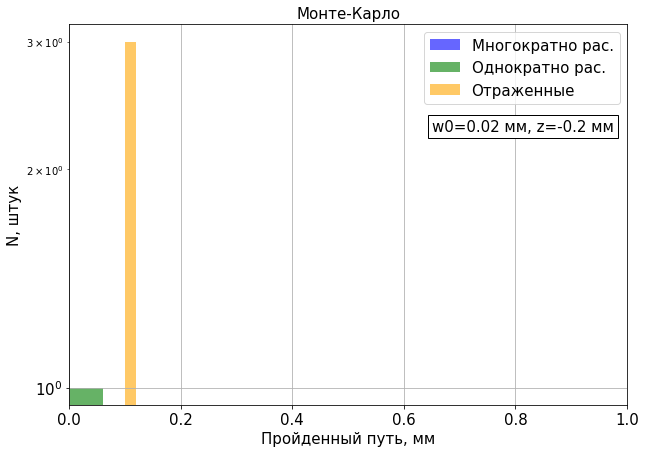

----------------------------------------------------------------------------------------------------
CPU times: total: 2.2 s
Wall time: 2.22 s


In [81]:
%%time
%matplotlib inline

# ------------  Параметры среды ----------------
n = np.array([1.0, 1.45, 1.33, 1.37])
#линии разделения слоев
Layers = np.array([0.0, 0.05, 0.2, 10])
#коэф рассеяния/поглощения
mu_a = np.array([0.0, 1.5, 1, 0.1])
mu_s = np.array([0.0001, 11, 11, 5])
#длина свободного пробега в слое
l_ph = 1/(mu_s+mu_a)
#фактор анизотропии
g = np.array([0.9999, 0.92, 0.85, 0.92])

w0_gs_list = np.array([0.02, 0.05, 0.10, 0.20, 0.40])
z_list = np.array([-0.25, -0.5, -1, -2, -4])
#коэффиценты френeля по энергии
T_01 = (4*n[1]*n[0])/(n[0]+n[1])**2
R_12 = ((n[1]-n[2])/(n[1]+n[2]))**2
T_12 = (4*n[2]*n[1])/(n[2]+n[1])**2
R_23 = ((n[2]-n[3])/(n[2]+n[3]))**2

for z_in in z_list[0:1]:
    # перетяжка в ткани или нет
    if z_in >= 0:
        func = initial
    else:
        func = initial_in_tissue
        
    for w0_gs in w0_gs_list[0:1]:
        # ------------  Параметры пучка ----------------
        #Длина Релея
        z0_gs = np.pi*w0_gs**2/0.001 #(mm)
        #Аппертура генерации
        NA0 = 0.001/w0_gs/np.pi

        # ------------  Начальные данные ----------------
        #Ширина пятна
        w0 = w0_gs*np.sqrt(1 + (z_in/z0)**2)

        # ------------  Monte-Carlo ----------------
        #Количесвто фотонов
        N = 25000
        mas_sc, mas_sc_one = Monte_Carlo(N, n, Layers, mu_a, mu_s, l_ph, g, w0, z_in, w0_gs, z0_gs, NA0, func)
        
        # ------------  Отраженнные фотоны ----------------        
        #Ширина пятна на плоскостях гарниц слоев
        z_w0 = abs(z_in)
        w_01 = w0_gs*np.sqrt(1 + ((2*Layers[2]-z_w0)/z0)**2)
        w_02 = w0_gs*np.sqrt(1 + ((2*Layers[3]-z_w0)/z0)**2)
        coupling1 = ((w0*w_01)/(w0**2+w_01**2))**2
        coupling2 = ((w0*w_02)/(w0**2+w_02**2))**2
        
        mas_refl = int(N*np.e**(-(mu_a[1]+mu_s[1])*0.1)*T_01**2*R_12*coupling1)*[2*Layers[1]]+int(N*np.e**(-(mu_a[1]+mu_s[1])*0.4)*T_01**2*T_12**2*R_23*coupling2)*[2*Layers[2]]
        
        # ------------  Результаты  ----------------
        fig, ax = plt.subplots(figsize =(10, 7))
        g_text = plt.text(0.65, 0.72, '', fontsize=15,
                            bbox=dict(facecolor='white', edgecolor='black'), 
                            transform=ax.transAxes)
        plt.tick_params(axis='both', which='major', labelsize=15)
        ax.hist(mas_sc, 140, (0, 2.5), alpha = 0.6, color = 'blue', log=True)
        ax.hist(mas_sc_one, 30, (0, 0.6), alpha = 0.6, color = 'green', log=True)
        ax.hist(mas_refl, 30, (0, 0.6), alpha = 0.6, color = 'orange', log=True)
        plt.grid()
        plt.title('Монте-Карло', fontsize=15)
        plt.xlabel('Пройденный путь, мм', fontsize=15)
        plt.ylabel('N, штук', fontsize=15)
        plt.legend(['Многократно рас.','Однократно рас.', 'Отраженные'], fontsize = 15)
        g_text.set_text('w0={:.2f} мм, z={:.1f} мм'.format(w0_gs, z_in))
        plt.xlim([0,1])
        name = f'scat_refl_{int(N/10**6)}_w0-{w0_gs}mm_z-{z_in}mm.png'
                                                                                           
        fig.savefig(f'C:\\Users\\User\\Desktop\\ОКТ-диплом\\Монте Карло\\тест3\\графики\\z={z_in}\\{name}', dpi=500)
        
        nam = f'z={z} mm, w0={w0_gs} mm.txt'
        with open(f'C:\\Users\\User\\Desktop\\ОКТ-диплом\\Монте Карло\\тест3\\данные\\z={z_in}\\{nam}', 'w') as f:
            f.write(f'{mas_sc}\n')
            f.write(f'{mas_sc_one}\n')
            f.write(f'{mas_refl}\n')
            f.close()
#         fig, ax = plt.subplots(figsize =(10, 7))
#         g_text = plt.text(0.6, 0.8, '', fontsize=15,
#                             bbox=dict(facecolor='white', edgecolor='black'), 
#                             transform=ax.transAxes)
#         plt.tick_params(axis='both', which='major', labelsize=15)
#         ax.hist(mas_refl, 30, (0, 0.6))
#         plt.grid()
#         plt.title('Отраженные фотоны', fontsize=15)
#         plt.xlabel('Пройденный путь, mm', fontsize=15)
#         plt.ylabel('N, штук', fontsize=15)
#         g_text.set_text('w0={:.2f} мм, z={:.1f} мм'.format(w0_gs, z))
#         plt.xlim([0,0.6])
#         name = f'refl_{int(N/10**6)}_w0-{w0_gs}mm_z-{z}mm.png'
#         fig.savefig(f'C:\\Users\\User\\Desktop\\ОКТ-диплом\\Монте Карло\\тест2\\отраженные\\{name}', dpi=500)
        
        # Show plot
        plt.show()
        print(100*'-')

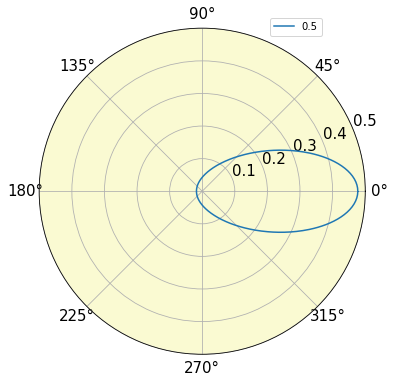

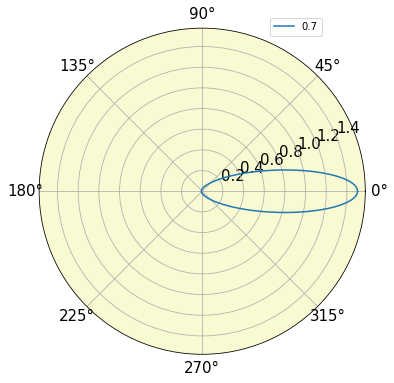

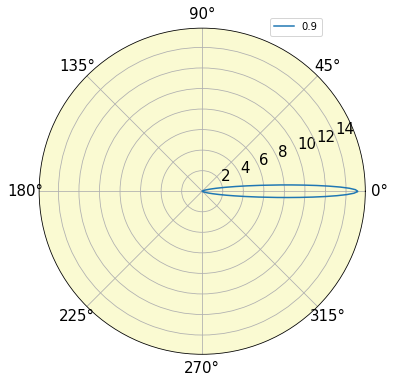

In [42]:
import math

angle = np.deg2rad(67.5) 

rads = np.arange(0, (2 * np.pi), 0.01)
g_mas = np.array([0.5, 0.7, 0.9])
for g in g_mas:
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection="polar", facecolor="lightgoldenrodyellow")  
    plt.tick_params(axis='both', which='major', labelsize=15)
    p = 1/4/np.pi*(1-g**2)/(1+g**2-2*g*np.cos(rads))**(3/2)
    plt.polar(rads, p, label = f'{g}')
    ax.legend(loc="lower left",
          bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))
    plt.show()
# display the polar plot

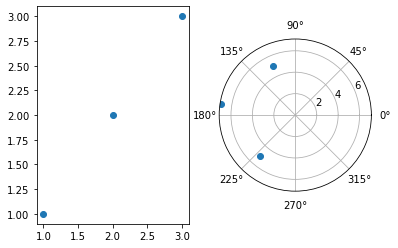

In [37]:
x = [1,2,3]
y = [1,2,3]
a = [2,3,4]
b = [5,7,5]

fig = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

ax1.scatter(x,y)
ax2.scatter(a,b)
plt.show()

In [60]:
print(np.array(10*[0.2, 0.4]))

[0.2 0.4 0.2 0.4 0.2 0.4 0.2 0.4 0.2 0.4 0.2 0.4 0.2 0.4 0.2 0.4 0.2 0.4
 0.2 0.4]


In [54]:
print(2*['a']+3*['b'])

['a', 'a', 'b', 'b', 'b']


In [73]:
a = np.array('[0.2 0.4 0.5]')

[0.2 0.4 0.5]
